In [1]:
# Here we look at the Vix data set: A market index that tracks volatility in the market
# From what I infer, high Vix prices indicate high volatility in the marketplace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# We do our initial tests with Bitcoin. We can expand this analysis later

coin_df = pd.read_csv('Data/coin_Bitcoin.csv')

coin_df.index = pd.to_datetime(coin_df['Date']).dt.date
coin_df.index = pd.DatetimeIndex(coin_df.index)

# Not useful
coin_df.drop('Date', axis=1, inplace=True)
coin_df.drop('SNo', axis=1, inplace=True)

coin_df.head()

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,
2013-04-29,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
# Next we read in the Vix dataset

new_column_names = {
    'DATE': 'Date',
    'OPEN': 'Open',
    'HIGH': 'High',
    'LOW': 'Low',
    'CLOSE': 'Close'
}

vix_df = pd.read_csv('index_data/VIX_History.csv')

vix_df.rename(columns=new_column_names, inplace=True)

vix_df.index = pd.to_datetime(vix_df['Date']).dt.date
vix_df.index = pd.DatetimeIndex(vix_df.index)

vix_df.drop('Date', axis=1, inplace=True)

vix_df.head()

,Open,High,Low,Close
Date,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19
1990-01-04,19.22,19.22,19.22,19.22
1990-01-05,20.11,20.11,20.11,20.11
1990-01-08,20.26,20.26,20.26,20.26


In [4]:
# Clearly, we can see we have data in Vix we will not need (since Bitcoin did not exist in 1990)
# Similarly, we should restrict both datasets to the time range they share
oldest_coin_date = coin_df.index.min()
oldest_vix_date = vix_df.index.min()
newest_coin_date  = coin_df.index.max()
newest_vix_date = vix_df.index.max()
print("Oldest date for Coin DF:", oldest_coin_date)
print("Most recent date for Coin DF:", newest_coin_date)
print()
print("Oldest date for Vix DF:", oldest_vix_date)
print("Most recent date for Vix DF:", newest_vix_date)

oldest_shared = max(oldest_coin_date, oldest_vix_date)
newest_shared = min(newest_coin_date, newest_vix_date)

print()
print("Oldest date shared:", oldest_shared)
print("Most recent date shared:", newest_shared)

Oldest date for Coin DF: 2013-04-29 00:00:00
Most recent date for Coin DF: 2021-02-27 00:00:00

Oldest date for Vix DF: 1990-01-02 00:00:00
Most recent date for Vix DF: 2021-03-26 00:00:00

Oldest date shared: 2013-04-29 00:00:00
Most recent date shared: 2021-02-27 00:00:00


In [5]:
vix_df = vix_df.loc[oldest_shared:newest_shared]
coin_df = coin_df.loc[oldest_shared:newest_shared]

In [6]:
# Now we have our data ready to go. 
# Let's take a subset of coin_df and calculate the "return" of each day
coin_return = pd.DataFrame(index=coin_df.index)
coin_return['coin_return'] = coin_df['Close'].pct_change()

vix_df_copy = vix_df.copy()
# Then drop the first row of both coin_return and vix_df_copy to get rid of NaN and preserve length
vix_df_copy.drop(vix_df.index[0], inplace=True)
coin_return.drop(coin_return.index[0], inplace=True)

# Then we need to drop the rows for dates not in both data sets
coin_dates = set(coin_return.index)
vix_dates = set(vix_df_copy.index)

for date in vix_dates.difference(coin_dates):
    vix_df_copy.drop(date, inplace=True)
for date in coin_dates.difference(vix_dates):
    coin_return.drop(date, inplace=True)

In [7]:
vix_df_copy.head()

,Open,High,Low,Close
Date,,,,
2013-04-30,13.71,14.28,13.51,13.52
2013-05-01,13.88,14.67,13.87,14.49
2013-05-02,14.48,14.48,13.58,13.59
2013-05-03,12.92,13.15,12.77,12.85
2013-05-06,13.06,13.19,12.66,12.66


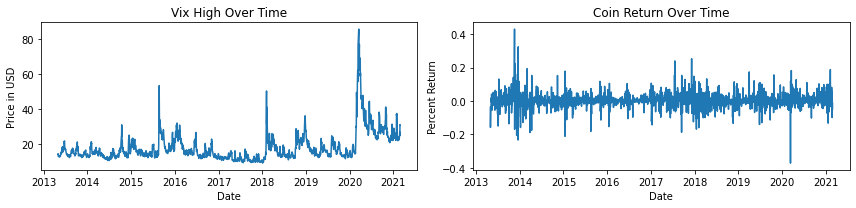

In [8]:
# A basic visualization of what the Vix data set looks like. Notice the spikes in volatility
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(vix_df_copy.index, vix_df_copy['High'])
ax1.set_title('Vix High Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price in USD')


# A basic visualization of the coin percent return
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(coin_return.index, coin_return['coin_return'])
ax2.set_title('Coin Return Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Percent Return')

plt.tight_layout()
plt.show()

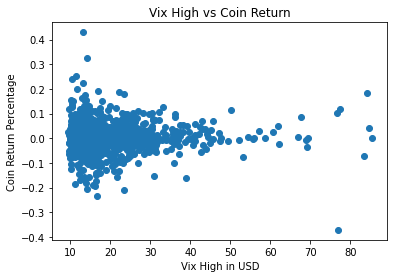

In [9]:
# Now let's try volatility vs coin return
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(vix_df_copy['High'], coin_return['coin_return'])
ax1.set_title("Vix High vs Coin Return")
ax1.set_xlabel("Vix High in USD")
ax1.set_ylabel("Coin Return Percentage")
plt.show()

In [10]:
# Let's try a regression on Sentiment on return: 
# > .2 then very good 0 < < 0.2 then good converse for bad and very bad
def get_sentiment(return_val):
    if return_val >= 0.2:
        return 'very good'
    elif return_val > 0 and return_val < 0.2:
        return 'good'
    elif return_val < 0 and return_val > -0.2:
        return 'bad'
    elif return_val <= 0.2:
        return 'very bad'
    else:
        return None
    

sentiment_df = pd.DataFrame(index=coin_return.index)
sentiment_df['sentiment'] = [get_sentiment(return_val) for return_val in coin_return['coin_return']]
sentiment_df.head(10)

,sentiment
Date,
2013-04-30,bad
2013-05-01,bad
2013-05-02,bad
2013-05-03,bad
2013-05-06,bad
2013-05-07,bad
2013-05-08,good
2013-05-09,bad
2013-05-10,good


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(vix_df_copy['High'], sentiment_df['sentiment'], test_size=0.2, random_state=0)
# Reshape X_train and X_test
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

In [12]:
# Now Logistic Regression
model = LogisticRegression()
model.fit(X_train, Y_train)


LogisticRegression()

In [13]:
y_pred = model.predict(X_test)

In [14]:
# Not bad considering a random guess is 25% accuracy
accuracy_score(Y_test, y_pred)

0.5532994923857868

In [15]:
from sklearn.metrics import mean_squared_error
le = LabelEncoder() # Use the label encoder to transform our classes into numerical values
le.fit(Y_test)
mean_squared_error(le.transform(y_pred), le.transform(Y_test))

0.4467005076142132